<a href="https://colab.research.google.com/github/travislatchman/Cardiac-Ultrasound-Image-Segmentation-and-Stroke-Volume-estimation/blob/main/Cardiac_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [445]:
import configparser
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2

config = configparser.ConfigParser()

DATA_PATH = "../MIA23_Project1_data/" #Path to folder with Patient Folders

In [446]:
filename = DATA_PATH + 'patient0015/Info_4CH.cfg'

# read the file contents into a string
with open(filename, 'r') as f:
    contents = f.read()
    
# print the contents of the file
print(contents)


ED: 27
ES: 1
NbFrame: 27
Sex: M
Age: 55
ImageQuality: Medium
LVedv: 82.5
LVesv: 30.5
LVef: 63.1



In [447]:
def read_patient_mhd_file(patient_number, file_prefix):
    file_path = DATA_PATH + f"patient{patient_number:04d}/patient{patient_number:04d}_{file_prefix}.mhd"

    # Read the mhd file
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)
    
    spacing = image.GetSpacing()
    
    return array, spacing[1]/spacing[0]

In [448]:
def view_image(image, aspectR, title=None):
    plt.imshow(image, cmap='gray', aspect=aspectR)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [449]:
#TAKEN FROM OPENCV DOCS   https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

def otsuValue(image):
    mask = (image > 0).astype(np.uint8)
    
    # find normalized_histogram, and its cumulative distribution function
    hist = cv2.calcHist([image],[0],mask,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    
    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        if q1 < 1.e-6 or q2 < 1.e-6:
            continue
        b1,b2 = np.hsplit(bins,[i]) # weights
        
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    return thresh

In [ ]:
### OLD VERSION

exampleFile = '2CH_sequence'
ED_2CH, aspect = read_patient_mhd_file(1, exampleFile)
ED_2CH = ED_2CH[8]
view_image(ED_2CH, aspect, title=exampleFile)
mask = (ED_2CH == 0)

converted = cv2.cvtColor(ED_2CH, cv2.COLOR_GRAY2RGB)
blurred = cv2.ximgproc.anisotropicDiffusion(converted, 0.2, 2, 10) 
#view_image(blurred, aspect, title=exampleFile)

gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
threshold = otsuValue(gray)
print(threshold)



invGamma = 0.6
table = np.array([((i / 255.0) ** invGamma) * 255 if i > threshold else i for i in np.arange(0, 256)]).astype("uint8")
thresholded = cv2.LUT(ED_2CH, table)


ret, thresholded = cv2.threshold(thresholded, threshold, 255, cv2.THRESH_BINARY_INV)
thresholded[mask] = 0
view_image(thresholded, aspect, title=exampleFile)

kernel = np.ones((25, 25), np.uint8)
thresholded = cv2.erode(thresholded, kernel, iterations=1)
thresholded = cv2.dilate(thresholded, kernel, iterations=1)
view_image(thresholded, aspect, title=exampleFile)


numRegions, label, stats, centroids = cv2.connectedComponentsWithStats(thresholded, 4, cv2.CV_32S)

largest = 0
index = 0
for i in range(numRegions):
    if i == 0: #Skip background
        continue
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]

    if w * h > largest:
        largest = w * h
        index = i

thresholded[labels != index] = 0
view_image(thresholded, aspect, title=exampleFile)


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(51, 51))
thresholded = cv2.dilate(thresholded, kernel, iterations=3)
thresholded = cv2.erode(thresholded, kernel, iterations=3)
view_image(thresholded, aspect, title=exampleFile)



kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6, 6))
smaller = cv2.erode(thresholded, kernel, iterations=1)
boundary = thresholded - smaller
view_image(boundary, aspect, title=exampleFile)

converted[boundary > 0] = [255, 0, 0]
view_image(converted, aspect, title=exampleFile)

#exampleFile = '4CH_ED_gt'
#gt, aspect = read_patient_mhd_file(1, exampleFile)
#view_image(gt[0], aspect, title=exampleFile)


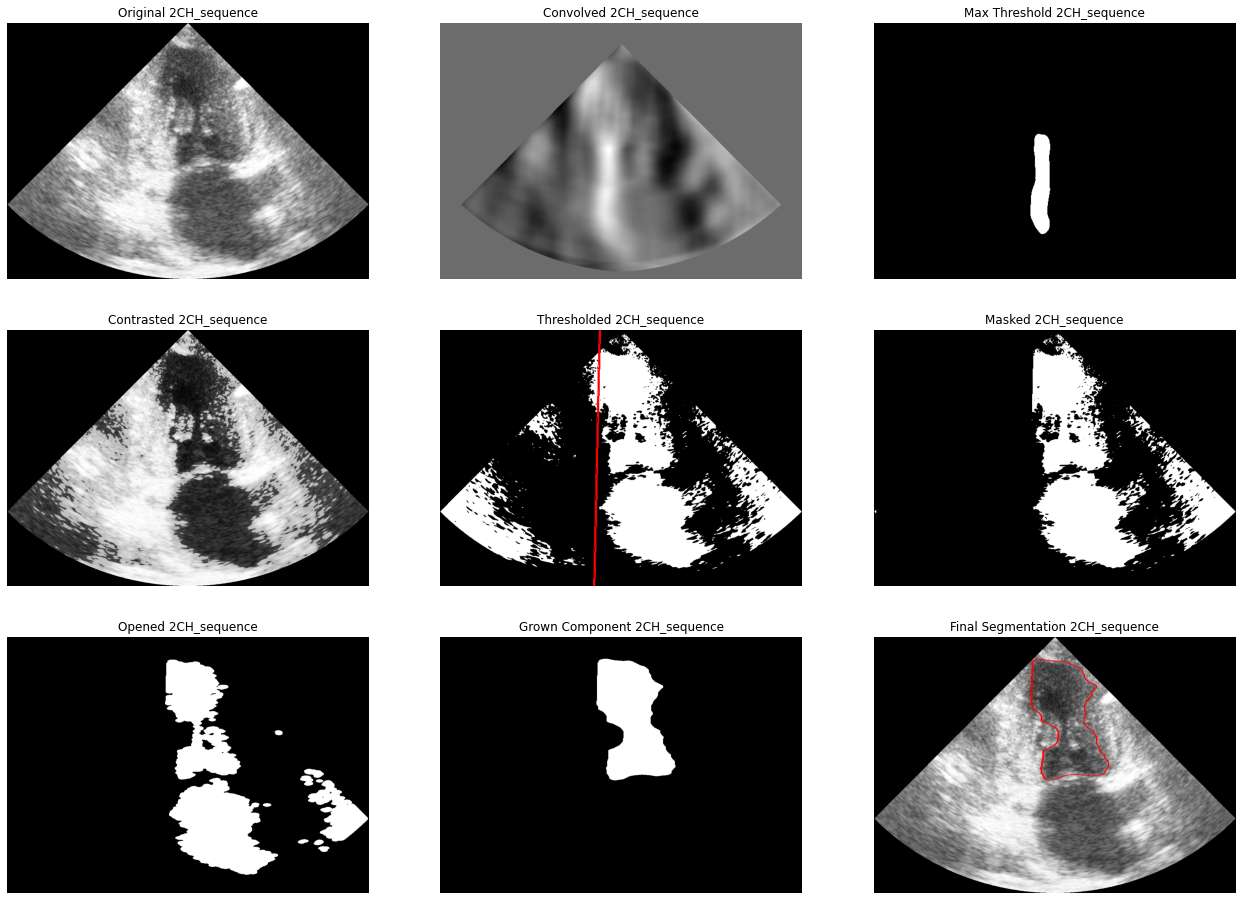

In [450]:
def setSubplot(subplot, image, aspectRatio, title):
    subplot.imshow(image, cmap='gray', aspect=aspectRatio)
    subplot.set_title(title)
    subplot.axis('off')

def segmentImage(image, aspectRatio, title, display, displayFinal):
    imageHeight = (image.shape)[0]
    if display:
        fig, ax = plt.subplots(3, 3, figsize=(22, 16))
        setSubplot(ax[0, 0], image, aspectRatio, 'Original ' + title)
    
    ultrasoundMask = (image == 0) #Mask outside the ultrasound range
    
    
    septumKernel = np.ones((120, 60), np.int8)
    septumKernel[:,30:] = -1
    convolved = cv2.filter2D(image, cv2.CV_32F, septumKernel)
    convolved[cv2.dilate(ultrasoundMask.astype(np.uint8), np.ones((50, 50), np.uint8), iterations=1) == 1] = 0 #Mask out dilated ultrasound part
    convolved = 255 * convolved / np.max(convolved) #Resacle to max = 255
    
    if display:
        setSubplot(ax[0, 1], convolved, aspectRatio, 'Convolved ' + title)
    
    convolved[convolved < 150] = 0 #Binarize to 0/1
    convolved[convolved > 0] = 1
    numRegions, label, stats, centroids = cv2.connectedComponentsWithStats(convolved.astype(np.uint8), 4, cv2.CV_32S)
    components = []
    for i in range(numRegions):
        if i == 0: #Skip background
            continue
        components.append([stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT], i])
    components = sorted(components)
    components.reverse()

    for i in range(1, len(components)):
        convolved[label == components[i][1]] = 0
    
    if display:
        setSubplot(ax[0, 2], convolved, aspectRatio, 'Max Threshold ' + title)
    
    x, y = np.nonzero(convolved)
    
    y -= 20 # Fuzzy correction to be on edge
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
   
    #RGB = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #blurred = cv2.ximgproc.anisotropicDiffusion(RGB, 0.2, 2, 10) 
    #setSubplot(ax[1, 0], blurred, aspectRatio, 'Anisotropic Diffusion ' + title)
    #gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    #threshold1 = otsuValue(gray)
    threshold = otsuValue(image) - 25
    
    invGamma = 0.6
    #table = np.array([((i / 255.0) ** invGamma) * 255 if i > threshold else i for i in np.arange(0, 256)]).astype("uint8")
    table = np.array([((i / 255.0) ** invGamma) * 255 if i > threshold else ((i / 255.0) ** (1/invGamma)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    corrected = cv2.LUT(image, table)
    
    if display:
        setSubplot(ax[1, 0], corrected, aspectRatio, 'Contrasted ' + title)
    #corrected = cv2.morphologyEx(corrected, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7, 7)), iterations=1)
    
    ret, thresholded = cv2.threshold(corrected, threshold, 255, cv2.THRESH_BINARY_INV)
    thresholded[ultrasoundMask] = 0
    RGB = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
    cv2.line(RGB, (0, int(-c/m)), (imageHeight, int((imageHeight-c)/m)), (255, 0, 0), 2)
    if display:
        setSubplot(ax[1, 1], RGB, aspectRatio, 'Thresholded ' + title)
    
    pts = np.array([[0,0],[0, int(-c/m)],[imageHeight, int((imageHeight-c)/m)],[0, imageHeight]], np.int32)
    cv2.fillPoly(thresholded, [pts], (0,0,0))
    if display:
        setSubplot(ax[1, 2], thresholded, aspectRatio, 'Masked ' + title)
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    closed = cv2.erode(thresholded, kernel, iterations=1)
    closed = cv2.dilate(closed, kernel, iterations=1)
    if display:
        setSubplot(ax[2, 0], closed, aspectRatio, 'Opened ' + title)
    

    numRegions, label, stats, centroids = cv2.connectedComponentsWithStats(closed, 4, cv2.CV_32S)
    components = []
    for i in range(numRegions):
        if i == 0: #Skip background
            continue
        if stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT] > 5000:
            components.append([stats[i, cv2.CC_STAT_TOP], i])
    components = sorted(components) #Pick topmost component
    closed[label != components[0][1]] = 0
    

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(41, 41))
    grown = cv2.dilate(closed, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7, 7)), iterations=1)
    
    grown = cv2.morphologyEx(grown, cv2.MORPH_CLOSE, kernel, iterations=2)
    #grown = cv2.dilate(closed, kernel, iterations=14)
    #grown = cv2.erode(grown, kernel, iterations=4)
    if display:
        setSubplot(ax[2, 1], grown, aspectRatio, 'Grown Component ' + title)
 
    smaller = cv2.erode(grown, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6, 6)), iterations=1)
    boundary = grown - smaller
    
    color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    color[boundary > 0] = [255, 0, 0]
    if display:
        setSubplot(ax[2, 2], color, aspectRatio, 'Final Segmentation ' + title)
    if displayFinal:
        view_image(color, aspectRatio, 'Final Segmentation')
    if display:
        plt.show()
    return boundary



exampleFile = '2CH_sequence'
ED_2CH, aspect = read_patient_mhd_file(4, exampleFile)
ED_2CH = ED_2CH[17]
boundary = segmentImage(ED_2CH, aspect, exampleFile, True, False)


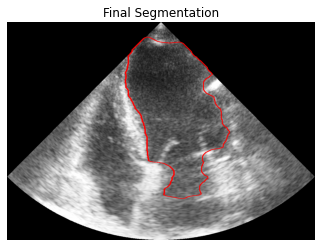

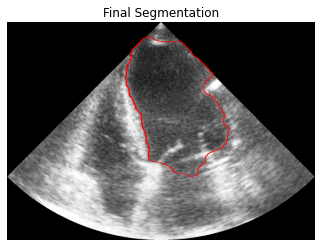

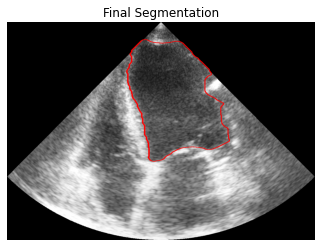

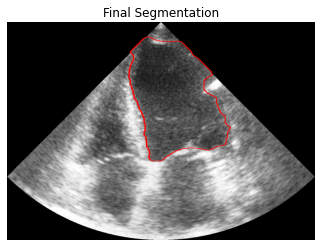

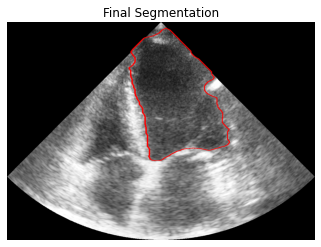

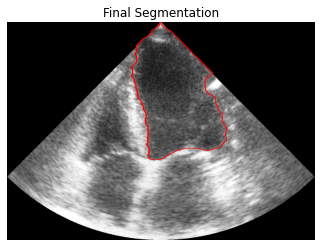

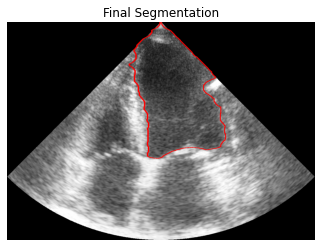

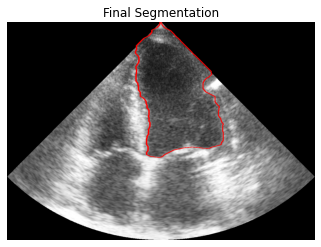

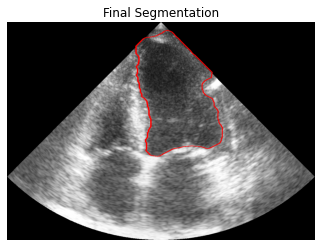

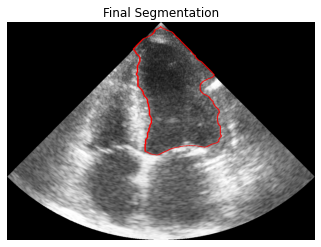

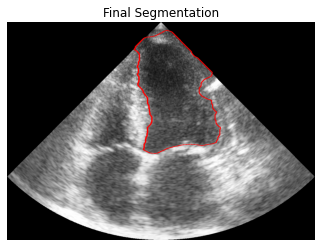

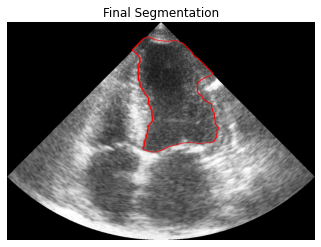

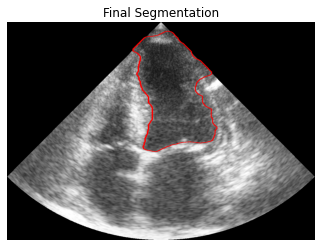

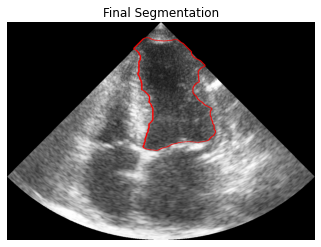

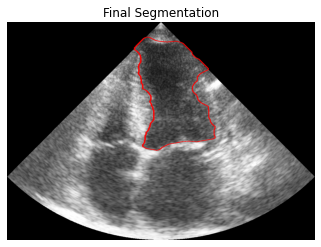

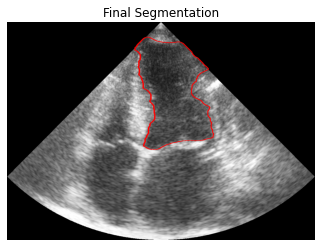

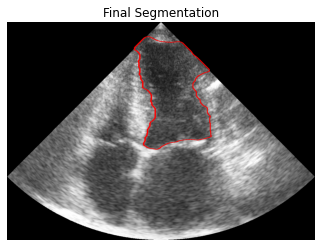

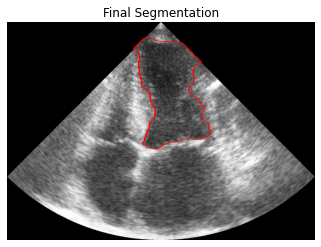

In [451]:
exampleFile = '4CH_sequence'
image, aspect = read_patient_mhd_file(4, exampleFile)
        
for i in range(len(image)):
    boundary = segmentImage(image[i], aspect, exampleFile, False, True)